In [4]:
from align import *

In [5]:
from collections import namedtuple
Opts = namedtuple('Opts', ['cuts', 'lang_dir', 'exp_dir'])

opts = Opts(
    cuts="/export/fs04/a12/rhuang/contextualizedASR/data/ec53_kaldi_heuristics8_2/cuts.jsonl.gz",
    lang_dir="/export/fs04/a12/rhuang/forced_alignment/data/lang_letter",
    exp_dir="/export/fs04/a12/rhuang/forced_alignment/exp/ec53_kaldi_heuristics8_2",
)

In [6]:
model, labels, sample_rate, device = load_model("cpu")
space_token = "|"

2023-01-28 22:27:59,900 - INFO - load_model:6 - torch: 1.10.1
2023-01-28 22:27:59,902 - INFO - load_model:7 - torchaudio: 0.10.1
2023-01-28 22:27:59,903 - INFO - load_model:13 - devide: cpu


KeyboardInterrupt: 

In [7]:
cuts = CutSet.from_file(opts.cuts)
cuts = cuts.resample(sample_rate)
cuts.describe()

lexicon = Lexicon(opts.lang_dir)
lexicon.disambig_pattern = re.compile(r"^#.+$")

T, L = get_T_and_L(lexicon, opts.lang_dir)

dataset = K2SpeechRecognitionDataset(
    input_strategy=AudioSamples(),
    # input_strategy=OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=80))),
    return_cuts=True,
)
sampler = DynamicBucketingSampler(cuts, max_duration=200, num_buckets=min(30, len(cuts)))
dl = DataLoader(dataset, batch_size=None, sampler=sampler, num_workers=0)

num_cuts = 0
log_interval = 20
try:
    num_batches = len(dl)
except TypeError:
    num_batches = "?"

2023-01-28 22:28:08,771 - INFO - __init__:168 - Loading pre-compiled /export/fs04/a12/rhuang/forced_alignment/data/lang_letter/Linv.pt


Cut statistics:
╒═══════════════════════════╤══════════╕
│ Cuts count:               │ 20       │
├───────────────────────────┼──────────┤
│ Total duration (hh:mm:ss) │ 00:01:28 │
├───────────────────────────┼──────────┤
│ mean                      │ 4.4      │
├───────────────────────────┼──────────┤
│ std                       │ 2.2      │
├───────────────────────────┼──────────┤
│ min                       │ 0.5      │
├───────────────────────────┼──────────┤
│ 25%                       │ 2.6      │
├───────────────────────────┼──────────┤
│ 50%                       │ 4.0      │
├───────────────────────────┼──────────┤
│ 75%                       │ 6.5      │
├───────────────────────────┼──────────┤
│ 99%                       │ 8.3      │
├───────────────────────────┼──────────┤
│ 99.5%                     │ 8.4      │
├───────────────────────────┼──────────┤
│ 99.9%                     │ 8.5      │
├───────────────────────────┼──────────┤
│ max                       │ 8.5      │


In [8]:
batches = [batch for batch_idx, batch in enumerate(dl)]

In [9]:
batch = batches[0]
audios = batch['inputs']
supervisions = batch["supervisions"]
texts = batch["supervisions"]["text"]
texts = [clean_transcript(text, labels, upper=True, space_symbol=space_token) for text in texts]
cut_ids = [cut.id for cut in batch["supervisions"]["cut"]]

print(len(batch))
print(batch["supervisions"]["cut"])

2
[MonoCut(id='session5_speaker5_5', start=31.68, duration=7.49, channel=0, supervisions=[SupervisionSegment(id='session5_speaker5_5', recording_id='session5_speaker5', start=0.0, duration=7.49, channel=0, text='EMMA THANK YOU VERY MUCH', language=None, speaker=None, gender=None, custom=None, alignment=None)], features=None, recording=Recording(id='session5_speaker5', sources=[AudioSource(type='file', channels=[0], source='/export/fs04/a12/rhuang/contextualizedASR/data/ec53_json//BAYZF_2018_Q4_20190227.wav')], sampling_rate=16000, num_samples=64561536, duration=4035.096, channel_ids=[0], transforms=None), custom=None), MonoCut(id='session12_speaker12_12', start=27.68, duration=7.49, channel=0, supervisions=[SupervisionSegment(id='session12_speaker12_12', recording_id='session12_speaker12', start=0.0, duration=7.49, channel=0, text='EMMA THANK YOU VERY MUCH', language=None, speaker=None, gender=None, custom=None, alignment=None)], features=None, recording=Recording(id='session12_speaker

In [10]:
Gs = []
for text in texts:
    Gs.append(make_grammar(text.split(space_token), lexicon))
Gs = k2.create_fsa_vec(Gs)

2023-01-28 22:28:17,101 - DEBUG - decorator:148 - deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'quiet'])
2023-01-28 22:28:17,105 - DEBUG - decorator:148 - deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'quiet'])
2023-01-28 22:28:17,108 - DEBUG - decorator:148 - deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2023-01-28 22:28:17,111 - DEBUG - decorator:148 - deprecate positional args: graphviz.backend.viewing.view(['quiet'])
2023-01-28 22:28:17,327 - DEBUG - decorator:148 - deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'escape_unescaped_quotes'])
2023-01-28 22:28:17,329 - DEBUG - decorator:148 - deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
2023-01-28 22:28:17,330 - DEBUG - decorator:148 - deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'

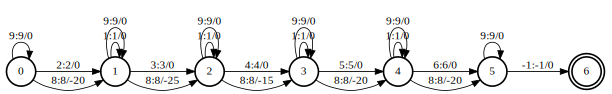

In [11]:
k2.to_dot(Gs[1])

In [12]:
T.shape, T.num_arcs

((219, None), 7024)

2023-01-28 22:24:14,173 - DEBUG - run_check:64 - run [PosixPath('dot'), '-Kdot', '-Tsvg']


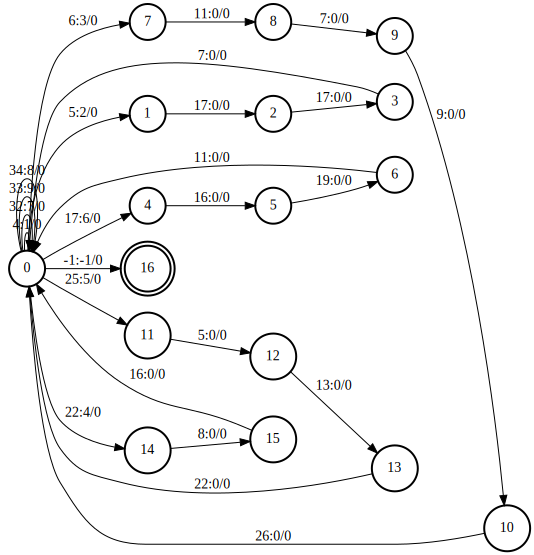

In [ ]:
k2.to_dot(L)

In [13]:
T = k2.arc_sort(T)
L = k2.arc_sort(L)
G = k2.arc_sort(Gs[0])

print("Intersecting L and G")
LG = k2.compose(L, G)
print(f"LG shape: {LG.shape}")

print("Connecting LG")
LG = k2.connect(LG)
print(f"LG shape after k2.connect: {LG.shape}")

print("Determinizing LG")
LG = k2.arc_sort(LG)
LG = k2.determinize(LG)

print("Connecting LG after k2.determinize")
LG = k2.connect(LG)

# LG = k2.remove_epsilon(LG)
# print(f"LG shape after k2.remove_epsilon: {LG.shape}")

LG = k2.arc_sort(LG)

print("Composing T and LG")
# CAUTION: The name of the inner_labels is fixed
# to `tokens`. If you want to change it, please
# also change other places in icefall that are using
# it.
TLG = k2.compose(T, LG, inner_labels="tokens")

print("Connecting TLG")
TLG = k2.connect(TLG)

print("Arc sorting LG")
TLG = k2.arc_sort(TLG)
print(f"TLG.shape: {TLG.shape}")

Intersecting L and G
LG shape: (22, None)
Connecting LG
LG shape after k2.connect: (22, None)
Determinizing LG
Connecting LG after k2.determinize
Composing T and LG
Connecting TLG
Arc sorting LG
TLG.shape: (162, None)


In [14]:
T = k2.arc_sort(T)
L = k2.arc_sort(L)
G = k2.arc_sort(Gs)

print("Intersecting L and G")
LG = k2.compose(L, G)
print(f"LG shape: {LG.shape} {LG.num_arcs}")

k2.to_dot(LG[0])


2023-01-28 22:28:35,136 - DEBUG - run_check:64 - run [PosixPath('dot'), '-Kdot', '-Tsvg']


Intersecting L and G
LG shape: (2, None, None) 72


In [ ]:
LG = k2.connect(LG)

LG = k2.determinize(LG)

: 

: 